In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder

In [29]:
data = pd.read_csv("../../PEMatrix/norm_NSAF_data2.csv", index_col = "assay_id")
meta = pd.read_csv("../../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
meta.sort_index(inplace=True)

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()

- Macro-f1: average of the f1 scores for each class
- Micro-f1: Micro averaging computes a global average F1 score by counting the sums of the True Positives (TP), False Negatives (FN), and False Positives (FP).
- Weighted-F1: The weighted-averaged F1 score is calculated by taking the mean of all per-class F1 scores while considering each class’s support.

# Protein based

### Effects of stringency of global filtering on performance

<AxesSubplot:xlabel='filter_percentage', ylabel='std'>

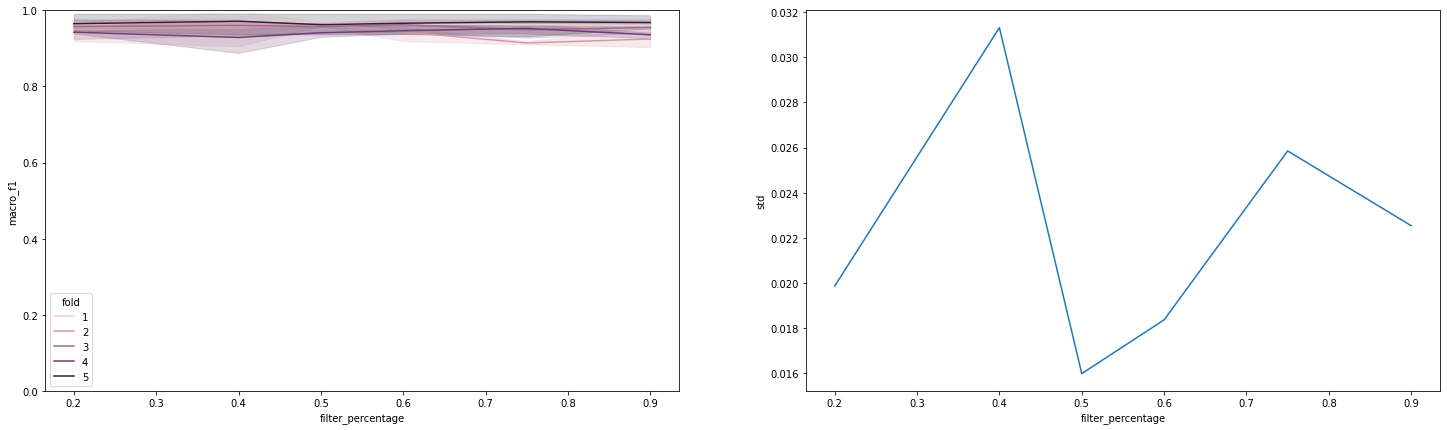

In [108]:
global_filter = pd.read_csv("global_filtering_skf.csv", sep=";")
fig,ax = plt.subplots(1,2,figsize=(25,7))
ax[0].set_ylim(0,1)
ax[1].set_ylabel("std")

sns.lineplot(data=global_filter, x='filter_percentage', y="macro_f1", hue = "fold", ax = ax[0])
sns.lineplot(data=global_filter[['filter_percentage', 'macro_f1']].groupby("filter_percentage").std().reset_index(), x='filter_percentage', y = 'macro_f1', ax=ax[1])

<AxesSubplot:xlabel='filter_percentage', ylabel='macro_f1'>

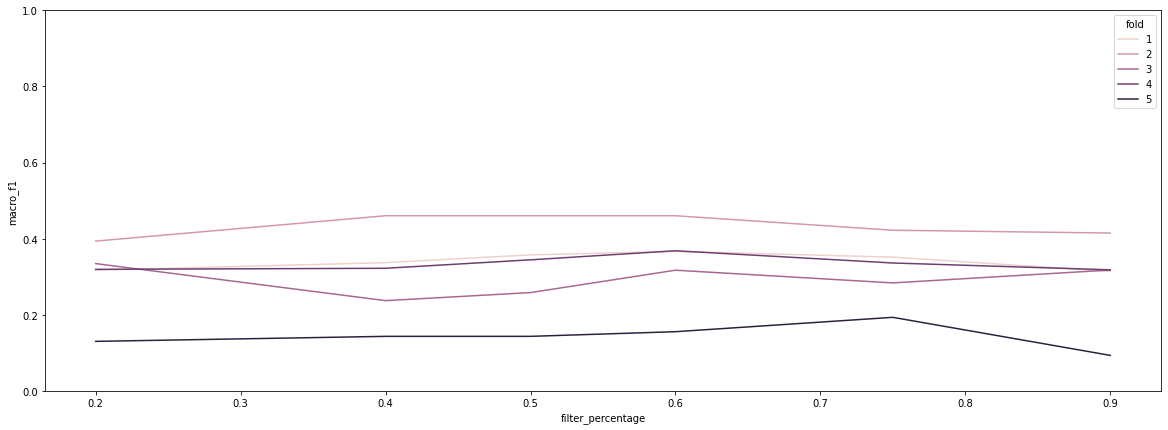

In [82]:
global_filter_PXDsplit = pd.read_csv("global_filtering_pxdsplit.csv", sep=';')
plt.figure(figsize=(20,7))
plt.ylim((0,1))
sns.lineplot(data=global_filter_PXDsplit, x='filter_percentage', y="macro_f1", hue = "fold")

(0.0, 1.0)

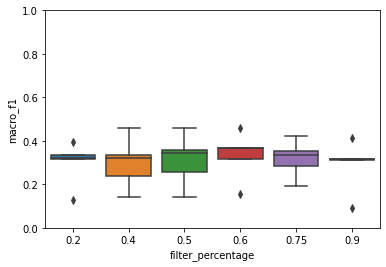

In [84]:
sns.boxplot(data=global_filter_PXDsplit, x='filter_percentage', y="macro_f1")
plt.ylim((0,1))

<AxesSubplot:title={'center':'Original samples'}, xlabel='model', ylabel='macro_f1'>

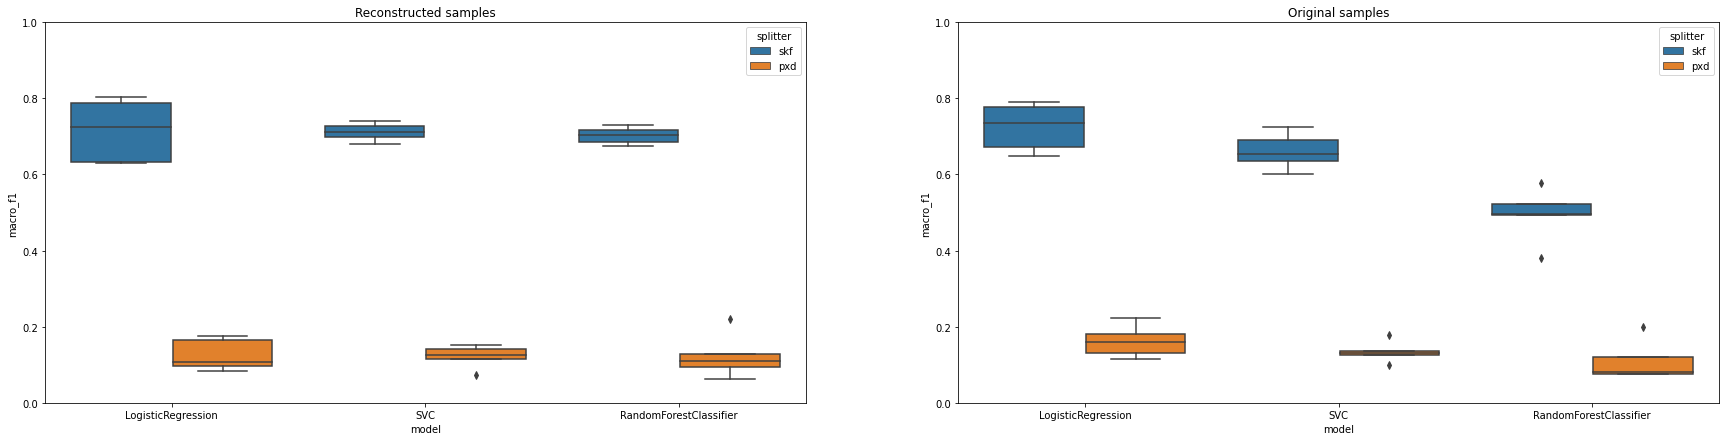

In [146]:
global_filter_PXDsplit = pd.read_csv("VAE_evaluation_split_comparison.csv", sep=';')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30,7))

ax1.set_ylim((0,1))
ax1.set_title("Reconstructed samples")

ax2.set_ylim((0,1))
ax2.set_title("Original samples")

sns.boxplot(data=global_filter_PXDsplit[global_filter_PXDsplit.prediction == "reconstruction"], x='model', y="macro_f1", hue = "splitter", ax = ax1)
sns.boxplot(data=global_filter_PXDsplit[global_filter_PXDsplit.prediction == "original"], x='model', y="macro_f1", hue = "splitter", ax=ax2)

In [99]:
def generate_cm(cm):
    parsed = [" "]
    for x in cm:
        try:
            int(x)
            parsed.append(x)
        except:
            if x == " ":
                if parsed[-1] == " ":
                    continue
                parsed.append(x)
    parsed = ''.join(parsed).split(" ")[1:]

    cm = []
    row = []
    count = 0
    for x in parsed:
        row.append(int(x))
        count += 1
        if count == 15:
            count = 0
            cm.append(row)
            row = []
    
    cm = pd.DataFrame(cm, columns = target_encoder.inverse_transform(unique_labels), index = target_encoder.inverse_transform(unique_labels))

    plt.figure(figsize=(12,6))
    plt.xlabel("Prediction")
    plt.ylabel("True")
    sns.heatmap(cm, annot=True)

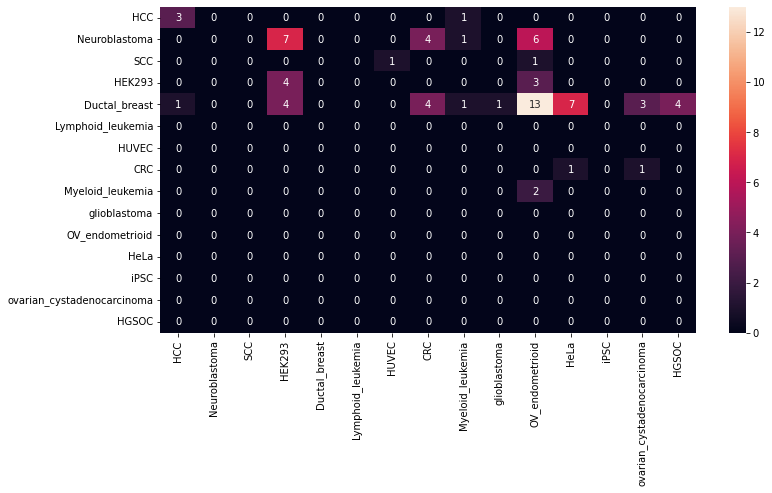

In [103]:
generate_cm(global_filter_PXDsplit.loc[45,"cm"])

In [147]:
for key, item in vae_grid.groupby(["model"])[["macro_f1", "best_params"]]:
    print(vae_grid.groupby(["model"])[["macro_f1", "best_params"]].get_group(key), "\n\n")

    macro_f1                                        best_params
0   0.573080  {'C': 23.543495662020792, 'class_weight': {2: ...
1   0.654071  {'C': 23.543495662020792, 'class_weight': {2: ...
2   0.510527  {'C': 72.99762485258339, 'class_weight': {2: 2...
3   0.662024  {'C': 72.99762485258339, 'class_weight': {2: 2...
8   0.650339  {'C': 16.52767498766199, 'class_weight': {2: 2...
9   0.661941  {'C': 16.52767498766199, 'class_weight': {2: 2...
10  0.572894  {'C': 21.259964106262046, 'class_weight': None...
11  0.710645  {'C': 21.259964106262046, 'class_weight': None... 


    macro_f1                                        best_params
6   0.662242  {'n_estimators': 69, 'max_depth': None, 'crite...
7   0.648033  {'n_estimators': 69, 'max_depth': None, 'crite...
14  0.667717  {'n_estimators': 65, 'max_depth': 40, 'criteri...
15  0.650093  {'n_estimators': 65, 'max_depth': 40, 'criteri... 


    macro_f1                                        best_params
4   0.626552  {'C': 85.00997045452

<AxesSubplot:title={'center':'Original samples'}, xlabel='fold', ylabel='macro_f1'>

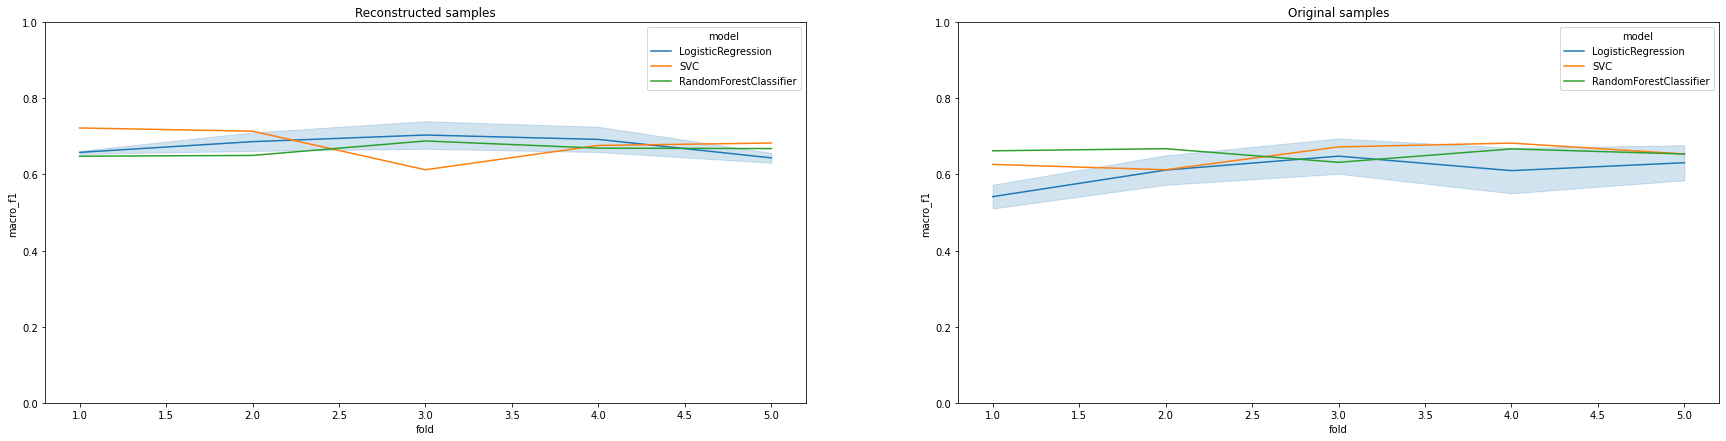

In [148]:
vae_grid = pd.read_csv("VAE_evaluation_grid_search.csv", sep=";")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30,7))

ax1.set_ylim((0,1))
ax1.set_title("Reconstructed samples")

ax2.set_ylim((0,1))
ax2.set_title("Original samples")

sns.lineplot(data=vae_grid[vae_grid.prediction == "reconstruction"], x='fold', y="macro_f1", hue="model",ax = ax1)
sns.lineplot(data=vae_grid[vae_grid.prediction == "original"], x='fold', y="macro_f1", hue="model", ax=ax2)

Performance of global filtering on splitting full pxd projects seems to be very dependent on which projects are splitted. Additionally, global filtering does not appear to impact model performance that much

In [23]:
knn_imputation = pd.read_csv("global_filtering_skf_KNNimputation.csv", sep = ";")

<AxesSubplot:xlabel='filter_percentage', ylabel='macro_f1'>

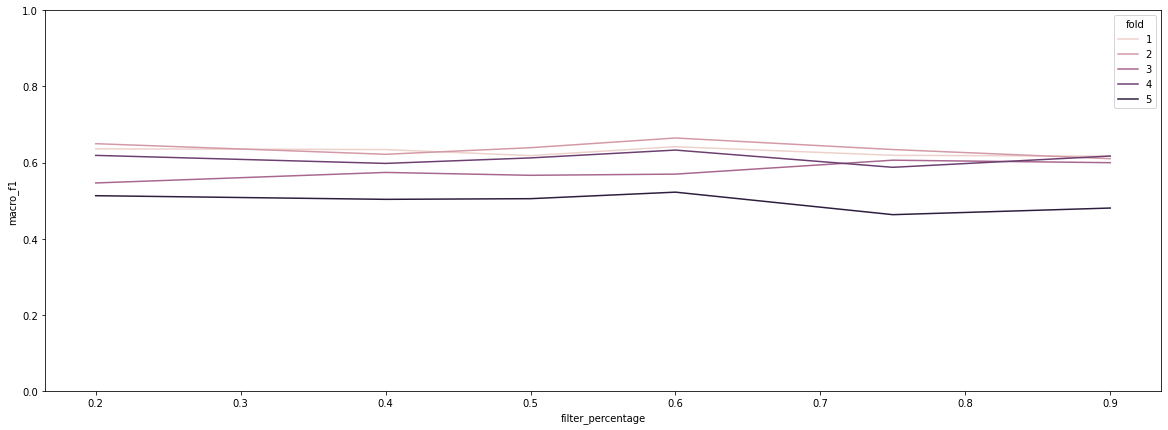

In [25]:
plt.figure(figsize=(20,7))
plt.ylim((0,1))
sns.lineplot(data=knn_imputation, x='filter_percentage', y="macro_f1", hue = "fold")

In [27]:
global_filter.groupby("filter_percentage").mean()

,fold,micro_f1,macro_f1,weighted_f1,proteins
filter_percentage,,,,,
0.20,3.0,0.729705,0.623869,0.712730,4794.8
0.40,3.0,0.745127,0.644778,0.730952,3203.6
0.50,3.0,0.739320,0.630859,0.725508,2609.8
0.60,3.0,0.733476,0.622225,0.722222,2082.8
0.75,3.0,0.741206,0.642136,0.731193,1349.0
0.90,3.0,0.702502,0.598535,0.691192,632.2


In [28]:
knn_imputation.groupby("filter_percentage").mean()

,fold,micro_f1,macro_f1,weighted_f1,proteins
filter_percentage,,,,,
0.20,3.0,0.693092,0.592824,0.678680,4794.0
0.40,3.0,0.687248,0.586264,0.672054,3202.6
0.50,3.0,0.685325,0.588277,0.671530,2605.8
0.60,3.0,0.694978,0.606233,0.684709,2081.2
0.75,3.0,0.687173,0.582072,0.676872,1347.6
0.90,3.0,0.679537,0.584879,0.667142,635.8


KNN imputation generally performs worse than lowest value imputation, regardless of protein filtering.

In [4]:
nf_50 = pd.read_csv("nf_50_LVI.csv", sep = ";")

                        micro_f1  macro_f1  weighted_f1
model                                                  
LGBMClassifier          0.697134  0.578152     0.672696
LogisticRegression      0.733824  0.611741     0.715362
RandomForestClassifier  0.687519  0.569883     0.651698
SVC                     0.552300  0.437505     0.531239


<AxesSubplot:xlabel='model', ylabel='macro_f1'>

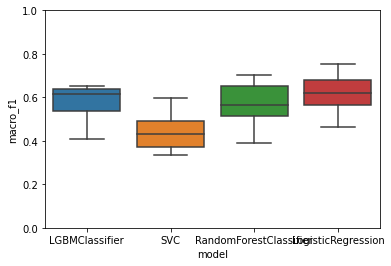

In [10]:
print(nf_50.groupby(["model"]).mean()[["micro_f1", "macro_f1", "weighted_f1"]])
plt.ylim((0,1))
sns.boxplot(data=nf_50, x='model', y="macro_f1")

Biological filtering: Filter the proteis that occur in x% per class. Keep or delete the proteins that do not occur in x% of samples per class of the samples in the class

<AxesSubplot:xlabel='model', ylabel='macro_f1'>

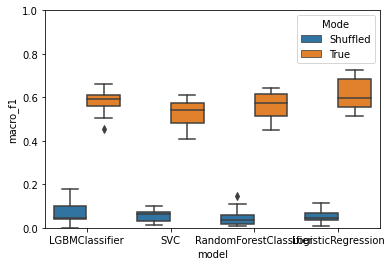

In [6]:
# Keeping the proteins

plt.ylim((0,1))
sns.boxplot(data=pd.read_csv("bf_70_keep_LVI.csv", sep = ";"), x='model', y="macro_f1", hue="Mode")

<AxesSubplot:xlabel='model', ylabel='macro_f1'>

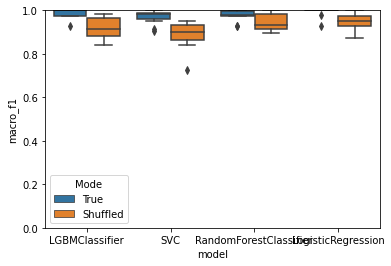

In [7]:
# Deleting the proteins: as control, they were shuffled

plt.ylim((0,1))
sns.boxplot(data=pd.read_csv("bf_70_LVI.csv", sep = ";"), x='model', y="macro_f1", hue="Mode")

Feature selection methods

In [143]:
fs = pd.read_csv("feature_selection_comparison_edit.csv", sep=";")

<AxesSubplot:xlabel='selector', ylabel='macro_f1'>

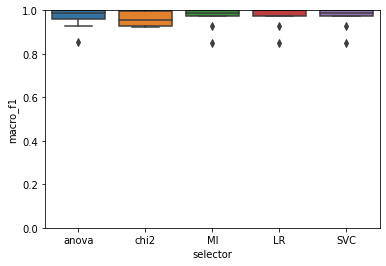

In [144]:
plt.ylim((0,1))
sns.boxplot(data = fs, x="selector", y="macro_f1")

In [35]:
fs_range

,model,fold,micro_f1,macro_f1,weighted_f1,cm,cutoff,oversampler
0,LogisticRegression,1,0.730769,0.646878,0.709921,[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 ...,6000,SMOTETomek
1,SVC,1,0.653846,0.600476,0.632875,[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 ...,6000,SMOTETomek
2,RandomForestClassifier,1,0.673077,0.579596,0.645480,[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 ...,6000,SMOTETomek
3,LogisticRegression,1,0.711538,0.635310,0.689906,[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 ...,4500,SMOTETomek
4,SVC,1,0.653846,0.564404,0.627616,[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 ...,4500,SMOTETomek
...,...,...,...,...,...,...,...,...
130,SVC,9,0.647059,0.506667,0.632026,[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]\n [0 0 0 0 0 ...,1500,SMOTETomek
131,RandomForestClassifier,9,0.647059,0.521429,0.657656,[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]\n [0 0 0 0 0 ...,1500,SMOTETomek
132,LogisticRegression,9,0.686275,0.531929,0.693071,[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]\n [0 0 0 0 0 ...,500,SMOTETomek
133,SVC,9,0.686275,0.512821,0.665535,[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]\n [0 0 0 0 0 ...,500,SMOTETomek


In [34]:
fs_range = pd.read_csv("feature_selection_cutoff.csv", sep=";")

<AxesSubplot:xlabel='cutoff', ylabel='macro_f1'>

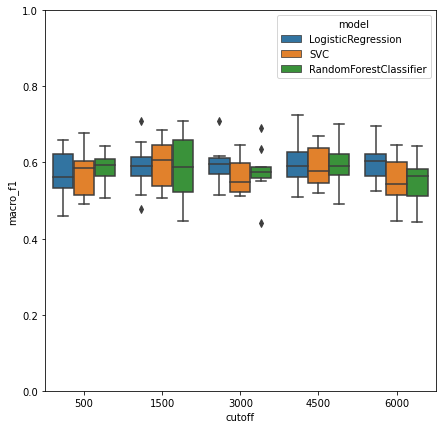

In [38]:
plt.figure(figsize=(7,7))
plt.ylim((0,1))
sns.boxplot(data=fs_range, x="cutoff", y="macro_f1", hue="model")

<AxesSubplot:xlabel='cutoff', ylabel='macro_f1'>

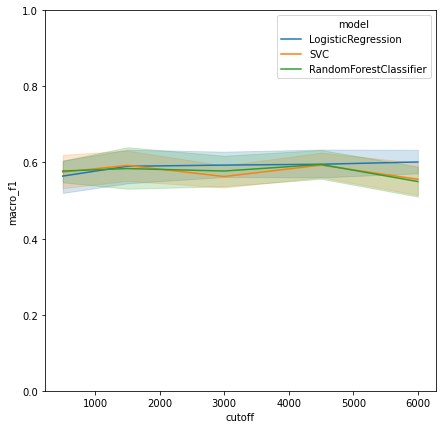

In [50]:
plt.figure(figsize=(7,7))
plt.ylim((0,1))
sns.lineplot(data=fs_range, x="cutoff", y="macro_f1", hue="model")

## Comparing scaling methods on log transformed and exponentiated dataset

In [10]:
scaling_comp

,model,fold,micro_f1,macro_f1,weighted_f1,cm,scaler,oversampler,data_type
0,LogisticRegression,1,0.673077,0.532574,0.647318,[[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]\n [0 0 0 1 0 ...,minmaxScaler,SMOTETomek,exp_data
1,LogisticRegression,1,0.673077,0.532574,0.647318,[[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]\n [0 0 0 1 0 ...,standardScaler,SMOTETomek,exp_data
2,SVC,1,0.653846,0.531092,0.636760,[[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]\n [0 0 0 1 0 ...,minmaxScaler,SMOTETomek,exp_data
3,SVC,1,0.634615,0.523482,0.623454,[[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]\n [0 0 0 1 0 ...,standardScaler,SMOTETomek,exp_data
4,RandomForestClassifier,1,0.653846,0.528011,0.638311,[[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]\n [0 0 0 1 0 ...,minmaxScaler,SMOTETomek,exp_data
...,...,...,...,...,...,...,...,...,...
115,LogisticRegression,10,0.803922,0.671139,0.792566,[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 ...,standardScaler,SMOTETomek,log-transformed
116,SVC,10,0.764706,0.638809,0.748065,[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 ...,minmaxScaler,SMOTETomek,log-transformed
117,SVC,10,0.764706,0.637271,0.753193,[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 ...,standardScaler,SMOTETomek,log-transformed
118,RandomForestClassifier,10,0.764706,0.630919,0.748109,[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 ...,minmaxScaler,SMOTETomek,log-transformed


<AxesSubplot:title={'center':'log NSAF'}, xlabel='scaler', ylabel='macro_f1'>

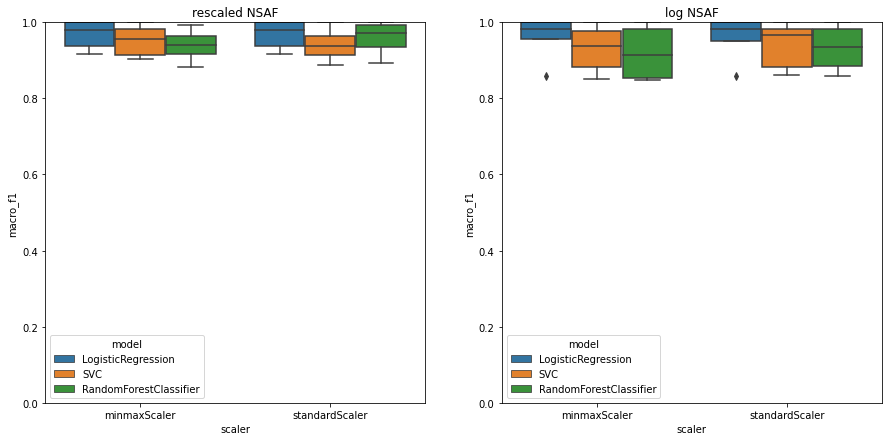

In [88]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

scaling_comp = pd.read_csv("scaling_comparison.csv", sep=";")

ax[0].set_ylim((0,1))
ax[1].set_ylim((0,1))

ax[0].set_title("rescaled NSAF")
ax[1].set_title("log NSAF")

sns.boxplot(data = scaling_comp[scaling_comp.data_type == "exp_data"], x = "scaler", y = "macro_f1", hue = "model", ax = ax[0])
sns.boxplot(data = scaling_comp[scaling_comp.data_type == "log-transformed"], x = "scaler", y = "macro_f1", hue = "model", ax = ax[1])

<AxesSubplot:ylabel='model'>

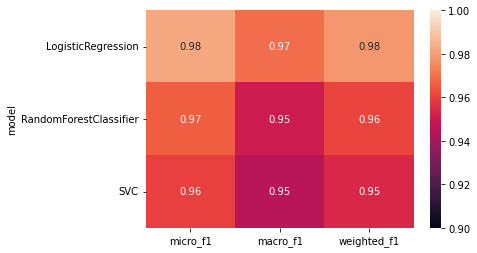

In [97]:
sns.heatmap(scaling_comp[scaling_comp.data_type == "exp_data"].groupby("model").mean()["micro_f1 macro_f1 weighted_f1".split()], annot=True, vmin=.9, vmax=1)

<AxesSubplot:ylabel='model'>

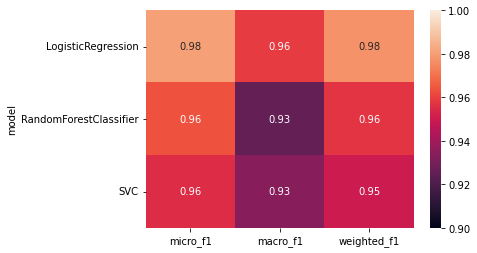

In [98]:
sns.heatmap(scaling_comp[scaling_comp.data_type == "log-transformed"].groupby("model").mean()["micro_f1 macro_f1 weighted_f1".split()], annot=True, vmin=.9, vmax=1)

## Comparison of filtering and oversampling methods

In [3]:
filter_oversample = pd.read_csv('filter_oversampling_comparison.csv', sep =";")

In [26]:
comp_filter = filter_oversample[filter_oversample.filter_type == "feature_selection"]
bio_filter = filter_oversample[filter_oversample.filter_type == "biological"]
glob_filter = filter_oversample[filter_oversample.filter_type == "global"]

<AxesSubplot:xlabel='filter_type', ylabel='macro_f1'>

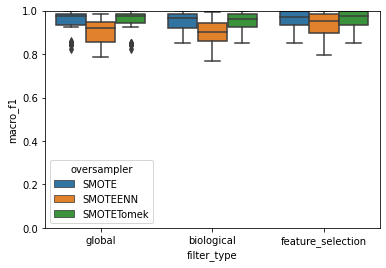

In [29]:
plt.ylim((0,1))
sns.boxplot(data = filter_oversample, x="filter_type", y = "macro_f1", hue = "oversampler")

<AxesSubplot:xlabel='proteins', ylabel='macro_f1'>

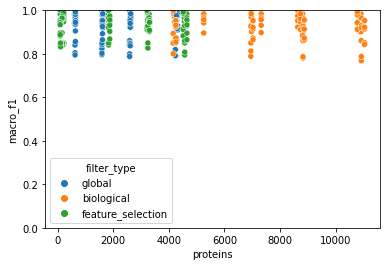

In [43]:
plt.ylim((0,1))
sns.scatterplot(data=filter_oversample, x="proteins", y="macro_f1", hue="filter_type")

In [6]:
filter_oversample[filter_oversample.filter_type == "biological"]

,model,fold,micro_f1,macro_f1,weighted_f1,cm,filter_type,oversampler,filter_percentage,proteins
24,SVC,1,0.980769,0.974603,0.978022,[[ 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,biological,SMOTE,0.25,10854
25,SVC,1,0.865385,0.902616,0.862026,[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 4 0 1 0 ...,biological,SMOTEENN,0.25,10854
26,SVC,1,0.980769,0.974603,0.978022,[[ 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,biological,SMOTETomek,0.25,10854
27,RandomForestClassifier,1,1.000000,1.000000,1.000000,[[ 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,biological,SMOTE,0.25,10854
28,RandomForestClassifier,1,0.884615,0.924444,0.884615,[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 5 0 0 0 ...,biological,SMOTEENN,0.25,10854
...,...,...,...,...,...,...,...,...,...,...
379,SVC,5,0.846154,0.873042,0.855076,[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 5 0 0 0 ...,biological,SMOTEENN,0.90,4250
380,SVC,5,0.942308,0.952843,0.935715,[[ 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,biological,SMOTETomek,0.90,4250
381,RandomForestClassifier,5,0.923077,0.924664,0.918040,[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 5 0 0 0 ...,biological,SMOTE,0.90,4250
382,RandomForestClassifier,5,0.846154,0.854444,0.857051,[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 5 0 0 0 ...,biological,SMOTEENN,0.90,4250


It is weird that the classes can be classified very accurately with only 92 proteins

Comparing performance of VAE

In [15]:
vae_eval = pd.read_csv("VAE_evaluation2.csv", sep=';')

<AxesSubplot:xlabel='model', ylabel='macro_f1'>

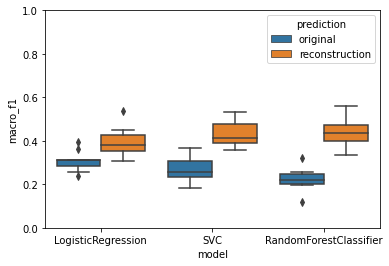

In [16]:
# Predicting on the original sample set fails. Tests are now running where the test samples are also reconstructed by the autoencoder. Hopefully this will give better results.
plt.ylim((0,1))
sns.boxplot(data = vae_eval, x="model", y = "macro_f1", hue = "prediction")

<AxesSubplot:xlabel='model', ylabel='macro_f1'>

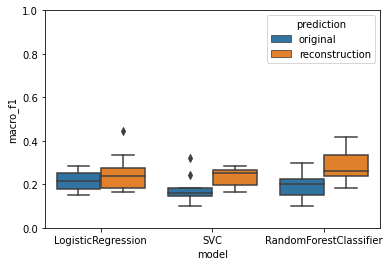

In [19]:
# with dropouts
vae_eval = pd.read_csv("vae_evaluation_dropout.csv", sep=';')
plt.ylim((0,1))
sns.boxplot(data = vae_eval, x="model", y = "macro_f1", hue = "prediction")

Grid search results

<AxesSubplot:title={'center':'GNB'}, xlabel='variable', ylabel='value'>

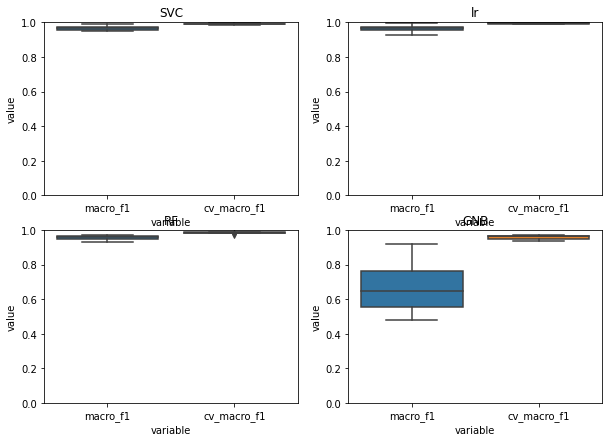

In [149]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(10,7))
grid_search = pd.read_csv("grid_search50.csv", sep=';')

ax1.set_title("SVC")
ax2.set_title("lr")
ax3.set_title("RF")
ax4.set_title("GNB")

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim(0,1)

sns.boxplot(data = grid_search[grid_search.model == "SVC"]["macro_f1 cv_macro_f1".split()].melt(), x="variable", y = "value", ax=ax1)
sns.boxplot(data = grid_search[grid_search.model == "LogisticRegression"]["macro_f1 cv_macro_f1".split()].melt(), x="variable", y = "value", ax=ax2)
sns.boxplot(data = grid_search[grid_search.model == "RandomForestClassifier"]["macro_f1 cv_macro_f1".split()].melt(), x="variable", y = "value", ax=ax3)
sns.boxplot(data = grid_search[grid_search.model == "GaussianNB"]["macro_f1 cv_macro_f1".split()].melt(), x="variable", y = "value", ax=ax4)

<AxesSubplot:xlabel='model', ylabel='macro_f1'>

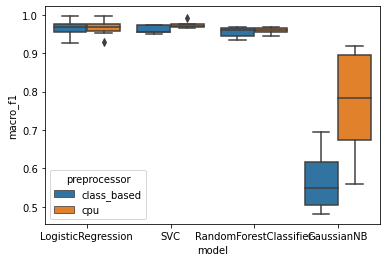

In [150]:
sns.boxplot(data=grid_search, x="model", y="macro_f1", hue="preprocessor")

In [152]:
print("LR")
for i, param in grid_search[(grid_search.preprocessor=="cpu") & (grid_search.model == "LogisticRegression")]["macro_f1 best_params".split()].iterrows():
    print(param["macro_f1"], param["best_params"])

print("SVC")
for i, param in grid_search[(grid_search.preprocessor=="cpu") & (grid_search.model == "SVC")]["macro_f1 best_params".split()].iterrows():
    print(param["macro_f1"], param["best_params"])

print("RF")
for i, param in grid_search[(grid_search.preprocessor=="cpu") & (grid_search.model == "RandomForestClassifier")]["macro_f1 best_params".split()].iterrows():
    print(param["macro_f1"], param["best_params"])

print("GNB")
for i, param in grid_search[(grid_search.preprocessor=="cpu") & (grid_search.model == "GaussianNB")]["macro_f1 best_params".split()].iterrows():
    print(param["macro_f1"], param["best_params"])

LR
0.9548864994026284 {'C': 8.050027107018083, 'class_weight': None, 'dual': False, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.9289683434844724 {'C': 29.55446605672465, 'class_weight': None, 'dual': False, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
0.9680709534368072 {'C': 66.34993763157473, 'class_weight': None, 'dual': False, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.9680709534368072 {'C': 17.816473574594237, 'class_weight': None, 'dual': False, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
0.9962234461054288 {'C': 24.91229868324631, 'class_weight': {2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}, 'dual': False, 'max_iter': 

# Reactome based

In [6]:
reactome_results = pd.read_csv("pathway_subset_selection.csv", sep =";")
lr_reactome_results = reactome_results[reactome_results.model == "RandomForestClassifier"]

<AxesSubplot:xlabel='pathways', ylabel='macro_f1'>

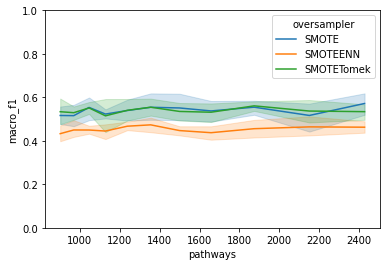

In [7]:
plt.ylim((0,1))
sns.lineplot(data = lr_reactome_results, x="pathways", y="macro_f1", hue = "oversampler")